###### Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from scipy.ndimage import convolve

from src.NN_sans_bias import ConstrainedMLPClassifier

In [3]:
np.random.seed(1717)

###### Define useful functions

In [4]:

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                     weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


def plot_sample(x, img_size=(8, 8)):
    plt.figure(figsize=(4.2, 4))
    plt.imshow(x.reshape(img_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

def inversion_symmetric_features(X, image_shape=(8,8)):
    n_samples, n_features = X.shape
    assert n_features==image_shape[0]*image_shape[1]
    _X = X.reshape(n_samples, *image_shape)
    result = _X*np.roll(_X, shift=-1, axis=2)
    return result.reshape(n_samples, n_features)

def random_permutation_inversion_symmetric_features(X, permutation):
    _, n_features = X.shape
    assert n_features==len(permutation)
    result = X * X[:, permutation]
    return result

def accuracy(y_true, y_pred):
    return (y_true==y_pred).sum()/len(y_true)

###### Initial data preparation

In [5]:
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling
X = 2*X - 1 # [-1,1] scaling

###### Training on the original dataset

In [6]:
hidden_layer_sizes = (10, 5)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model1 = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1)

model2 = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=2,
                                  fit_intercepts=False)

model1.fit(X_train, Y_train)
model2.fit(X_train, Y_train);

###### training on both the original data and the inverted data

In [8]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model1b = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1)

model2b = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=2,
                                  fit_intercepts=False)

_X_train_2 = np.vstack((X_train_2, -X_train_2))
_Y_train_2 = np.hstack((Y_train_2,  Y_train_2))

assert _X_train_2.shape[1]==64

model1b.fit(_X_train_2, _Y_train_2)
model2b.fit(_X_train_2, _Y_train_2);

###### train on symmetric features - first just the square features

In [9]:
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model3 = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1)

model4 = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=1,
                                  fit_intercepts=False)

XX_train_3 = X_train_3**2
XX_test_3 = X_test_3**2

model3.fit(XX_train_3, Y_train_3)
model4.fit(XX_train_3, Y_train_3);

######  train on symmetric features - gradient like features

In [10]:
X_train_4, X_test_4, Y_train_4, Y_test_4 = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model5 = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1)

model6 = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=1,
                                  fit_intercepts=False)

XX_train_4 = inversion_symmetric_features(X_train_4)
XX_test_4 = inversion_symmetric_features(X_test_4)

np.testing.assert_allclose(XX_test_4, inversion_symmetric_features(-X_test_4))

model5.fit(XX_train_4, Y_train_4)
model6.fit(XX_train_4, Y_train_4);

###### train with random permutation symmetric features

In [11]:
# test that the permutation features generator is working correctly
# if the using the identity permutation, the result should be just X**2

n_features = X.shape[1]

np.testing.assert_allclose(X**2,
                           random_permutation_inversion_symmetric_features(X, permutation=np.arange(n_features)))

In [12]:
X_train_5, X_test_5, Y_train_5, Y_test_5 = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model7 = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1)

model8 = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=1,
                                  fit_intercepts=False)

# fixed, but randomly selected permutation:
permutation = np.random.permutation(n_features)

XX_train_5 = random_permutation_inversion_symmetric_features(X_train_5, permutation=permutation)
XX_test_5 = random_permutation_inversion_symmetric_features(X_test_5, permutation=permutation)

np.testing.assert_allclose(XX_test_5, 
                           random_permutation_inversion_symmetric_features(-X_test_5, permutation=permutation))

model7.fit(XX_train_5, Y_train_5)
model8.fit(XX_train_5, Y_train_5);

###### plots and accuracy results

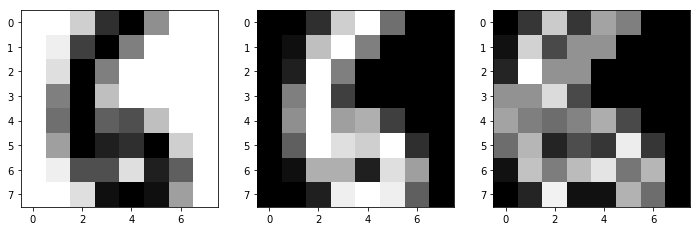

In [13]:
idx = 1173

x = -1 + 2*digits.data[idx]/16
y = digits.target[idx]
xx = inversion_symmetric_features(np.array([x]))

fig, axes = plt.subplots(1,3, figsize=(12, 4))

axes[0].imshow(x.reshape((8,8)), cmap=plt.cm.gray_r,
           interpolation='nearest')

axes[1].imshow(-x.reshape((8,8)), cmap=plt.cm.gray_r,
           interpolation='nearest')

axes[2].imshow(xx[0,:].reshape((8,8)), cmap=plt.cm.gray_r,
           interpolation='nearest');

# plt.savefig("./six_cubed.png")

In [14]:
print("non-symmetry-invariant models")

print("\nNo bias\n")

print("Training only on X_train, accuracy on X_test \n{:.3f}".format(
    accuracy(Y_test, model2.predict(X_test))))
print("Training only on X_train, accuracy on -X_test \n{:.3f}".format(
    accuracy(Y_test, model2.predict(-X_test))))

print("Training on X_train and -X_train, accuracy on X_test \n{:.3f}".format(
    accuracy(Y_test_2, model2b.predict(X_test_2))))
print("Training on X_train and -X_train, accuracy on -X_test \n{:.3f}".format(
    accuracy(Y_test_2, model2b.predict(-X_test_2))))

print("\nWith bias\n")

print("Training only on X_train, accuracy on X_test \n{:.3f}".format(
    accuracy(Y_test, model1.predict(X_test))))
print("Training only on X_train, accuracy on -X_test \n{:.3f}".format(
    accuracy(Y_test, model1.predict(-X_test))))

print("Training on X_train and -X_train, accuracy on X_test \n{:.3f}".format(
    accuracy(Y_test_2, model1b.predict(X_test_2))))
print("Training on X_train and -X_train, accuracy on -X_test \n{:.3f}".format(
    accuracy(Y_test_2, model1b.predict(-X_test_2))))

non-symmetry-invariant models

No bias

Training only on X_train, accuracy on X_test 
0.839
Training only on X_train, accuracy on -X_test 
0.001
Training on X_train and -X_train, accuracy on X_test 
0.119
Training on X_train and -X_train, accuracy on -X_test 
0.091

With bias

Training only on X_train, accuracy on X_test 
0.811
Training only on X_train, accuracy on -X_test 
0.021
Training on X_train and -X_train, accuracy on X_test 
0.679
Training on X_train and -X_train, accuracy on -X_test 
0.691


In [15]:
print("symmetry-invariant models")

print("\nNo bias\n")

print("Using square features \n{:.3f}".format(accuracy(Y_test_3, model4.predict(XX_test_3))))
print("Using gradient-like features \n{:.3f}".format(accuracy(Y_test_4, model6.predict(XX_test_4))))
print("Using randomized features \n{:.3f}".format(accuracy(Y_test_5, model8.predict(XX_test_5))))

print("\nWith bias\n")

print("Using square features \n{:.3f}".format(accuracy(Y_test_3, model3.predict(XX_test_3))))
print("Using gradient-like features \n{:.3f}".format(accuracy(Y_test_4, model5.predict(XX_test_4))))
print("Using randomized features \n{:.3f}".format(accuracy(Y_test_5, model7.predict(XX_test_5))))



symmetry-invariant models

No bias

Using square features 
0.646
Using gradient-like features 
0.840
Using randomized features 
0.814

With bias

Using square features 
0.659
Using gradient-like features 
0.866
Using randomized features 
0.821
